<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Monitor data flow usage using Watson Data APIs

## Introduction

It is useful to be able to generate monitoring reports which visualize usage of data flow runs. This tutorial uses the Watson Data Data Flow APIs to retrieve a filtered list of data flow run summaries for a project over a period of time in order to produce a usage report. This report will include graphs displaying totals for run completion states and data movement over time as well as a table displaying the same data grouped by data flow name.


### Language and Spark version
Python 3.5 Spark 2.1

### Prerequisites
This tutorial assumes you have an IBM Watson Data account with at least 1 project and you ran a data flow in the last day. See the following tutorial to get started [creating and running data flows using Watson Data APIs](https://dataplatform.ibm.com/exchange/public/entry/view/76deece1cf6f6f4bc3789678be94616d).

## Table of contents

1. [Setup](#setup)<br>
    1.1 [Environments](#setup1)<br>
    1.2 [Authorization](#setup2)<br>
2. [Retrieve Project IDs and Names](#projects)<br>
3. [Define a method to retrieve data flow run summaries](#summaries)<br>
4. [Display a usage report using matplotlib and pandas dataframes](#report)<br>
5. [Resources](#resources)

## <a id="setup"></a>1. Setup

In [1]:
from datetime import datetime, timedelta
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import requests
import json
import uuid

#### <a id="setup1"></a>1.1 Environments

The data flows service is currently deployed only to the US South region of IBM Cloud. Use this environment URL in place of {service_URL} in the examples below:

US south https://api.dataplatform.ibm.com

In [2]:
service_URL = "https://api.dataplatform.ibm.com"

#### <a id="setup2"></a>1.2 Authorization

An IAM Bearer token is required in order to access Watson Data APIs. For information on how to generate an IAM token see [here](http://ibm.biz/wdp-api#getting).

In [3]:
# Replace <IAM Access Token> with your generated IAM Access Token
authorization = "Bearer <IAM Access Token>"

### <a id="projects"></a>2. Retrieve Project IDs and Names
Call the projects API to retrieve a list of all projects in the account and store a map of IDs and names.

In [4]:
# GET https://api.dataplatform.ibm.com/v2/projects

project_response = requests.get(service_URL + "/v2/projects", headers={'Authorization': authorization})
projects_ = json.loads(project_response.text)["resources"]
projects = []

for project in projects_:
    projects.append([project["metadata"]["guid"], project["entity"]["name"]])

projects

[['09866227-b51f-4eb7-9322-0dd7bebb6642', 'bmcos-project-02032018'],
 ['88fc51bd-8ef5-47a5-9df6-a364129fc73d', 'Default Project'],
 ['c2254fed-404d-4905-9b8c-5102f195cc0d', 'BMCOS-PROJECT-12022018'],
 ['d12f9685-2693-4c84-af48-3eb6c71e3013', 'BMCOS-Project71117']]

### <a id="summaries"></a>3. Define a method to retrieve data flow run summaries
The `list_data_flow_run_summaries` method will retrieve a list of data flow runs for the given `project_id` that occurred later than `number_of_days` days ago.

To retrieve a list of the latest summaries of all data flow runs in a project, call the following GET method:

`GET https://{service_URL}/v2/data_flows/runs?project_id={project_id}`

The value of data_flow_id is the metadata.asset_id from your data flow. The value of data_flow_run_id is the metadata.asset_id from your data flow run. An example response from this API call might be:

```json
{
    "runs": [
        {
            "metadata": {
                "asset_id": "ed09488c-6d51-48c4-b190-7096f25645d5",
                "asset_type": "data_flow_run",
                "create_time": "2017-12-21T10:51:47.000Z",
                "creator": "demo_dataflow_user@mailinator.com",
                "href": "https://api.dataplatform.ibm.com/v2/data_flows/cfdacdb4-3180-466f-8d4c-be7badea5d64/runs/ed09488c-6d51-48c4-b190-7096f25645d5?project_id=ff1ab70b-0553-409a-93f9-ccc31471c218",
                "project_id": "ff1ab70b-0553-409a-93f9-ccc31471c218",
                "usage": {
                    "last_modification_time": "2017-12-21T10:51:47.923Z",
                    "last_modifier": "demo_dataflow_user@mailinator.com",
                    "last_access_time": "2017-12-21T10:51:47.923Z",
                    "last_accessor": "demo_dataflow_user@mailinator.com",
                    "access_count": 0
                }
            },
            "entity": {
                "data_flow_ref": "cfdacdb4-3180-466f-8d4c-be7badea5d64",
                "engine_state": {
                    "session_cookie": "route=Spark; HttpOnly; Secure",
                    "engine_run_id": "804d17bd-5ed0-4d89-ba38-ab7890d61e45"
                },
                "name": "my_dataflow",
                "rov": {
                    "mode": 0,
                    "members": []
                },
                "state": "finished",
                "summary": {
                    "completed_date": "2018-01-03T16:58:05.726Z",
                    "engine_elapsed_secs": 9,
                    "engine_completed_date": "2018-01-03T16:58:05.360Z",
                    "engine_started_date": "2018-01-03T16:57:56.211Z",
                    "engine_status_date": "2018-01-03T16:58:05.360Z",
                    "engine_submitted_date": "2018-01-03T16:57:46.044Z",
                    "total_bytes_read": 95466,
                    "total_bytes_written": 42142,
                    "total_rows_read": 766,
                    "total_rows_written": 336
                },
                "tags": []
            }
        }
    ]
}
```

By default, all data flow runs are returned regardless of which data flow they are associated with or their current state. Filtering and sorting can be applied on certain attributes using query parameters. For example `metadata.create_time=gt:2018-01-03T09:00:00.000` filters runs such that only those created after 9 AM on January 3rd 2018 will be returned. If multiple filters are specified, they will be combined with the logical AND operator. 

For a full list of attributes that can be filtered and sorted, see [Watson Data API documentation](http://ibm.biz/wdp-api#doc) under Documentation > Data flow runs.

In [5]:
def list_data_flow_run_summaries(project_id, number_of_days=1):
    # calculate current time - days in ISO format
    from_date = (datetime.utcnow() - timedelta(days=number_of_days)).isoformat()
    
    # GET https://api.dataplatform.ibm.com/v2/data_flows/runs
    filter_query = "&metadata.create_time=gt:" + from_date
    runs_response = requests.get(service_URL + "/v2/data_flows/runs?project_id=" + project_id + filter_query, headers={'Authorization': authorization})
    runs = json.loads(runs_response.text)["runs"]
    return runs

### <a id="report"></a>4. Display a usage report using matplotlib and pandas dataframes
The following code calls the `list_data_flow_run_summaries` method to retrieve the runs over the past day for the specified project. The json response is normalized and converted into a DataFrame so we can extract the information we need easily. This also allows us to structure the data so that it can be easily reshaped to produce different graphs.

The first graph is a time-series stacked bar graph that plots the hourly totals for completed states (finished, error, and so on).

The second graph is another time-series bar graph that plots the hourly totals of the number of megabytes read and written.

Finally the table displays total completed states megabytes read and written, grouped by run name.

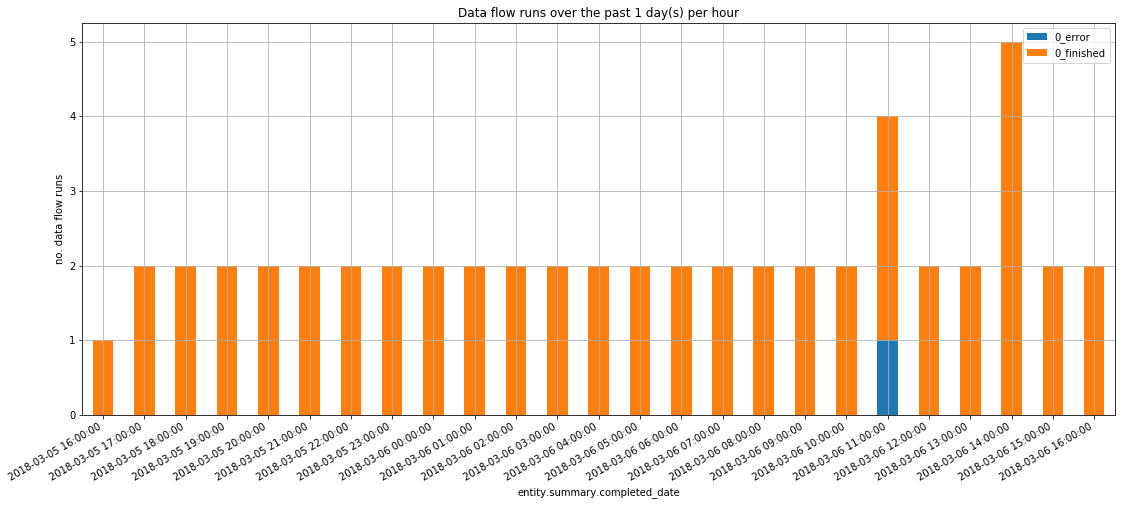

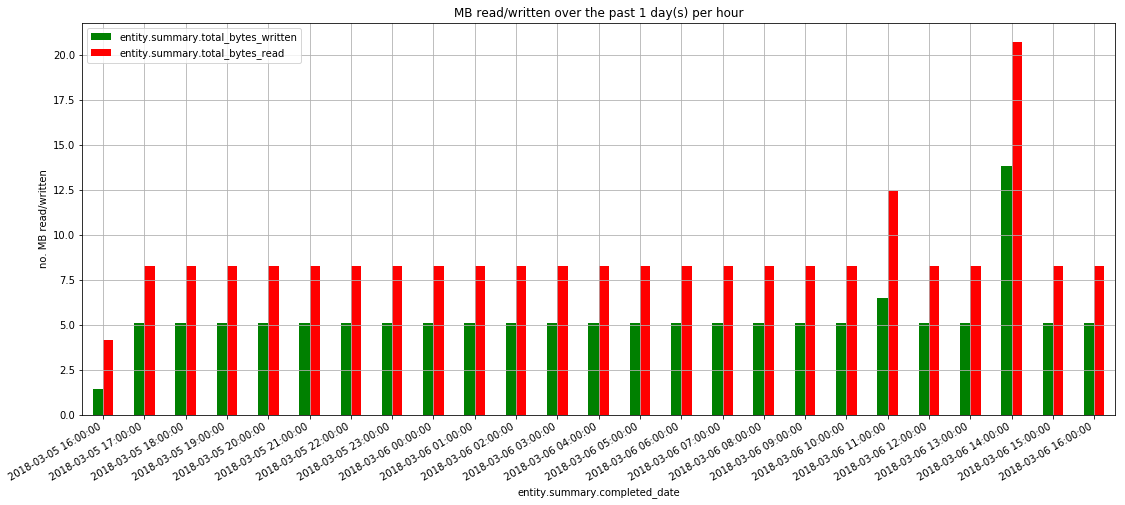

,0_error,0_finished,entity.summary.total_bytes_read,entity.summary.total_bytes_written
entity.name,,,,
BrokenDataFlow,1.0,0.0,0.000000,0.000000
Customer demographics and sales.csv_flow,0.0,26.0,107.895874,95.476982
RemoveDuplicates Customer Demographic and Sales flow,0.0,27.0,112.045715,38.349890


In [6]:
# The number of days we want to report usage for
days = 1

# The list of data flow run summaries from the BMCOS-PROJECT-12022018 project
# ['c2254fed-404d-4905-9b8c-5102f195cc0d', 'BMCOS-PROJECT-12022018']
runs = list_data_flow_run_summaries(projects[2][0], number_of_days=days)

# Convert the json response into a normalized DataFrame, selecting the dot-notated columns we require
runs_normalized = json_normalize(runs)
runs_df = pd.DataFrame(runs_normalized, columns=["entity.name", "entity.state", "entity.summary.completed_date", "entity.summary.total_bytes_written", "entity.summary.total_bytes_read"])

# We want to display some time-series data, so ensure the "entity.summary.completed_date" string is in datetime format and
# set this as the DataFrame index
runs_df['entity.summary.completed_date'] = pd.to_datetime(runs_df['entity.summary.completed_date'])
runs_df.index = runs_df['entity.summary.completed_date']
del runs_df['entity.summary.completed_date']

# reshape to in order to plot the total states grouped by hour
runs_df2 = pd.get_dummies(runs_df['entity.state'].apply(lambda x: pd.Series(x)))
runs_df2 = runs_df2.resample('H').sum()

# plot the time-series bar chart
ax = runs_df2.plot(kind='bar', x=runs_df2.index, stacked=True, align='center')
plt.title('Data flow runs over the past ' + str(days) + ' day(s) per hour')
plt.ylabel('no. data flow runs')
fig = plt.gcf()
fig.autofmt_xdate()
fig.set_size_inches(18.5, 8)
plt.grid()
plt.show()

# plot the time-series bar charts for MB read/written
runs_df3 = runs_df
runs_df3['entity.summary.total_bytes_read'] /= (1024 * 1024)
runs_df3['entity.summary.total_bytes_written'] /= (1024 * 1024)
runs_df3 = runs_df3.resample('H').sum()

runs_df3.fillna(0).plot(kind='bar', x=runs_df3.index, color=["green","red"], stacked=False, align='center')
plt.title('MB read/written over the past ' + str(days) + ' day(s) per hour')
plt.ylabel('no. MB read/written')
plt.grid()
fig = plt.gcf()
fig.autofmt_xdate()
fig.set_size_inches(18.5, 8)
plt.show()

# Display the count of completed states and MB read/written grouped by data flow run name
runs_df4 = runs_df
runs_df4.index = runs_df['entity.name']
del runs_df4['entity.name']
runs_df5 = pd.get_dummies(runs_df4['entity.state'].apply(lambda x: pd.Series(x)))
runs_df6 = pd.concat([runs_df5, runs_df4])
runs_df6.fillna(0).groupby(runs_df6.index).sum()

## <a id="resources"></a>5. Resources ##
For further information, see [Watson Data services](http://ibm.biz/wdp-api)

## Author
Damian Cummins is a Cloud Application Developer with the Data Refinery and Watson Data teams at IBM. 

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.